In [1]:
# Step 1: Setup Environment
import os
import numpy as np
from PIL import Image  # Import PIL for handling GIFs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 3: Download and Unzip Dataset (Uncomment if not done previously)
!pip install -q kaggle
# Upload your kaggle.json and run the below commands
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abhaysharma38/indian-folk-art-gallery-high-resolution-images
!unzip indian-folk-art-gallery-high-resolution-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/282.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/283.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/284.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/285.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/286.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/287.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/288.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/289.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/29.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/290.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/291

In [ ]:

# Step 4: Load and Preprocess Images
image_dir = '/content/folk-art-dataset-main/'  # Change if necessary
labels = os.listdir(image_dir)
IMG_SIZE = 128  # Image dimensions
images = []
image_labels = []

def load_images(image_dir, labels):
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                file_extension = img_file.split('.')[-1].lower()  # Get file extension
                if file_extension not in ['jpg', 'jpeg', 'png', 'gif']:  # List of supported formats
                    print(f"Unsupported format for image: {img_path}")
                    continue

                try:
                    # Use PIL for opening GIFs and other formats
                    image = Image.open(img_path)

                    # Convert image to RGB, handling palette images
                    image = image.convert('RGB')
                    image = image.resize((IMG_SIZE, IMG_SIZE))  # Resize to IMG_SIZE
                    image = np.array(image)  # Convert to numpy array

                    # Ensure the image shape is as expected
                    if image.shape == (IMG_SIZE, IMG_SIZE, 3):
                        images.append(image)
                        image_labels.append(label)
                    else:
                        print(f"Image shape mismatch for {img_path}: {image.shape}")
                except Exception as e:
                    print(f"Error loading image: {img_path} - {e}")

load_images(image_dir, labels)

# Convert images to numpy array
images = np.array(images, dtype='float32')
# Normalize pixel values to [0, 1]
images /= 255.0

# Map labels to numerical values
label_to_num = {label: idx for idx, label in enumerate(np.unique(image_labels))}
numerical_labels = np.array([label_to_num[label] for label in image_labels])
y_categorical = to_categorical(numerical_labels, num_classes=len(label_to_num))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, y_categorical, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_to_num), activation='softmax')(x)

# Define and compile the model
vgg16_model = Model(inputs=base_model.input, outputs=output)
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16 model
vgg16_history = vgg16_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


Epoch 1/50
808/808 [==============================] - 233s 287ms/step - loss: 2.8859 - accuracy: 0.1968 - val_loss: 2.3432 - val_accuracy: 0.3865
Epoch 2/50
808/808 [==============================] - 230s 285ms/step - loss: 2.4054 - accuracy: 0.3198 - val_loss: 2.1384 - val_accuracy: 0.4257
Epoch 3/50
808/808 [==============================] - 229s 283ms/step - loss: 2.2488 - accuracy: 0.3670 - val_loss: 1.9975 - val_accuracy: 0.4503
Epoch 4/50
808/808 [==============================] - 227s 281ms/step - loss: 2.1606 - accuracy: 0.3879 - val_loss: 1.9259 - val_accuracy: 0.4719
Epoch 5/50
808/808 [==============================] - 227s 281ms/step - loss: 2.0926 - accuracy: 0.4072 - val_loss: 1.8872 - val_accuracy: 0.4801
Epoch 6/50
808/808 [==============================] - 227s 282ms/step - loss: 2.0382 - accuracy: 0.4221 - val_loss: 1.8283 - val_accuracy: 0.4974
Epoch 7/50
808/808 [==============================] - 228s 283ms/step - loss: 1.9930 - accuracy: 0.4319 - val_loss: 1.7931 -

In [ ]:
val_loss, val_accuracy = vgg16_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


202/202 [==============================] - 46s 230ms/step - loss: 1.4019 - accuracy: 0.6153
Validation Loss: 1.4019395112991333, Validation Accuracy: 0.6153489351272583


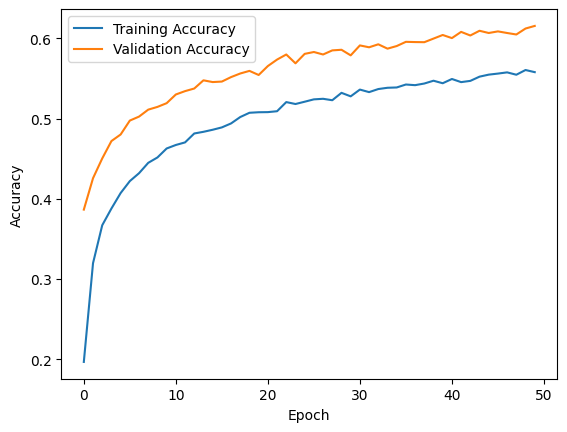

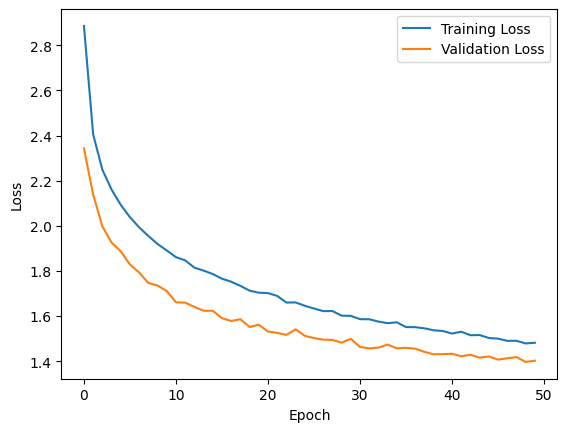

In [ ]:
import matplotlib.pyplot as plt

plt.plot(vgg16_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(vgg16_history.history['loss'], label='Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model_path = '/content/drive/MyDrive/indian_folk_art_vgg16_model50.h5'
vgg16_model.save(model_path)
print("Model saved successfully.")


Model saved successfully.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
